In [8]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# settings_path = 'settings/sam_4km_30min_30d.yaml'
# "settings/arpege_summer_30d.yaml",
#"settings/fv3_summer_30d.yaml"  ,
settings_paths = [                     
                "settings/obs_summer_30d.yaml", 
                "settings/arpege_summer_30d.yaml", 
                        #"settings/fv3_summer_30d.yaml", "settings/ifs_summer_30d.yaml", 
                "settings/mpas_summer_30d.yaml", 
                    #"settings/nicam_summer_30d.yaml", 
                "settings/sam_summer_30d.yaml", 
                    #"settings/um_summer_30d.yaml"
                    ]
# settings_paths = ["settings/nicam_summer_30d.yaml",  "settings/um_summer_30d.yaml"]
# settings_paths = [ "settings/sam_4km_30min_30d.yaml"]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 20,  nd=5, overwrite = True, dist_mask = False) for gr in grs]

lm = grs[0].get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

Data loaded from /homedata/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/ARPEGE_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/MPAS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/SAM_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/ARPEGE_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/MPAS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/SAM_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


In [15]:
# import os 
# for jd, gr in zip(jds, grs):
#     cloud_cond_var_ids = ["clouds_cond_prec_15", "vdcs_cond_prec_15", "mcs_cond_prec_15"]
#     for cloud_cond_var_id in cloud_cond_var_ids:
#         sigma = jd.prec.Sigma_cond_alpha_85_Prec
#         mcs_cond = gr.get_var_id_ds(cloud_cond_var_id)
#         sigma_mcs = mcs_cond.Rel_surface.sum(axis = 3) ## add this
#         mcs_cond["intersection_"+cloud_cond_var_id] = sigma_mcs/sigma ## add this 
#         mcs_cond_file = gr.get_var_ds_file(cloud_cond_var_id)
#         os.remove(mcs_cond_file)
#         mcs_cond.to_netcdf(mcs_cond_file)

In [16]:
np.logical_or(~ocean, ocean).shape

(60, 360, 1)

OBS_lowRes_Tropics
ARPEGE_lowRes_Tropics
MPAS_lowRes_Tropics
SAM_lowRes_Tropics


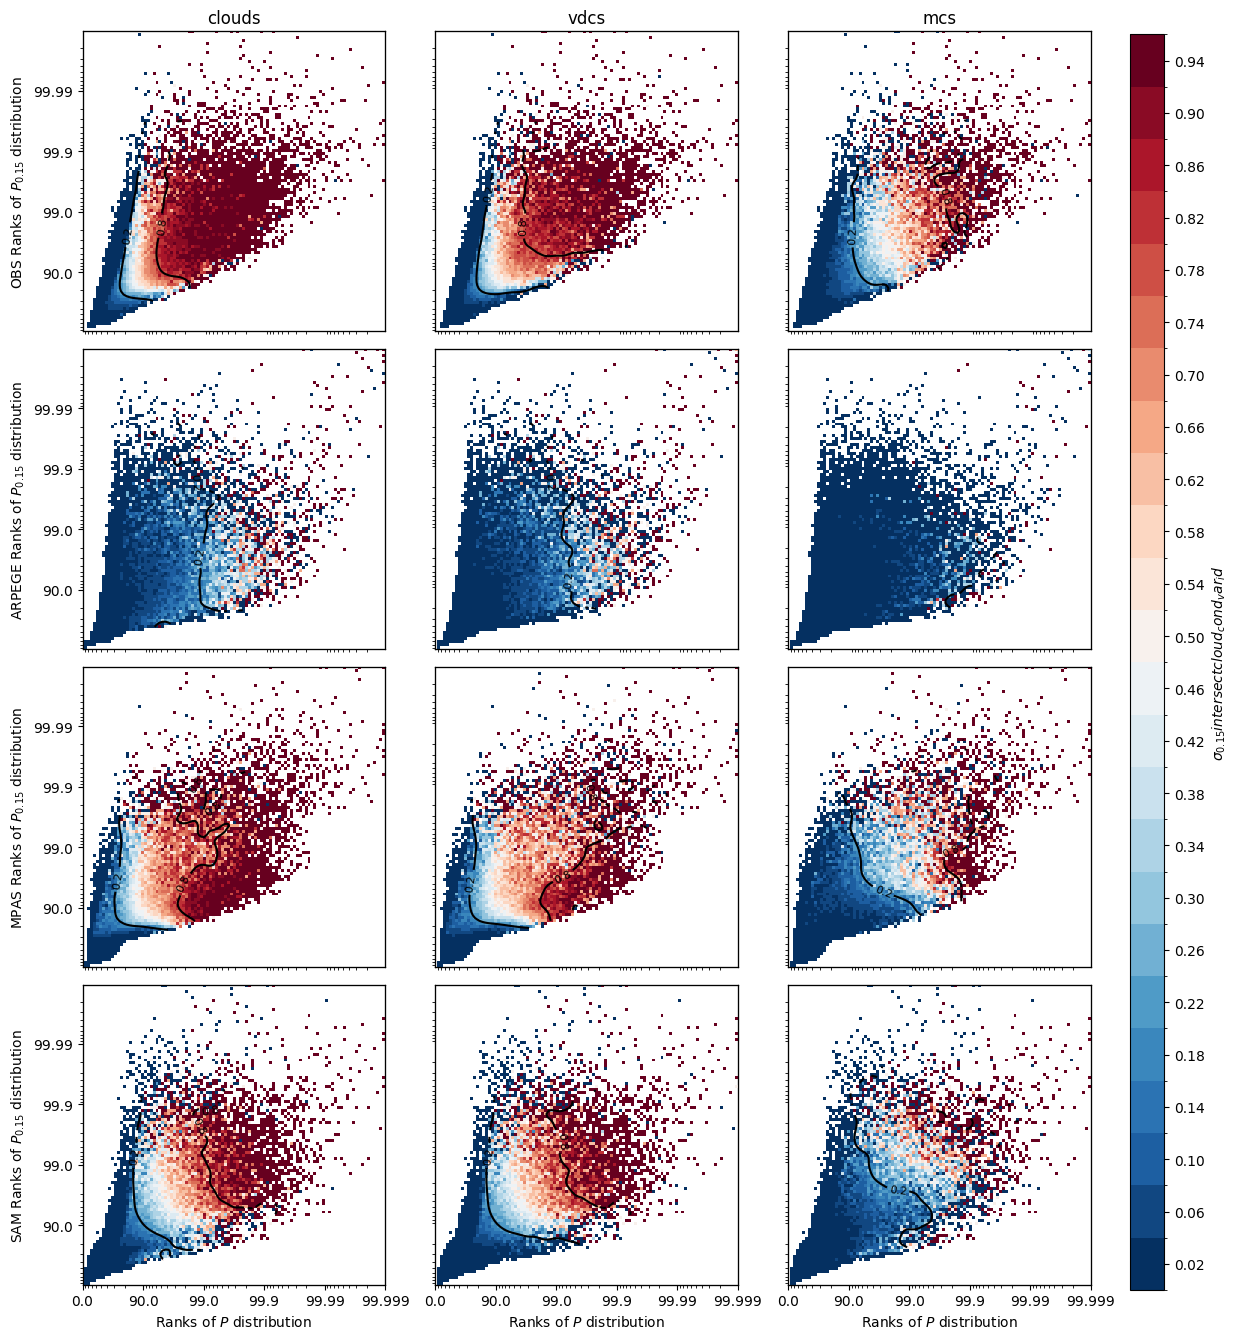

In [17]:
fig, axs  = plt.subplots(4, 3, figsize = (1.419*8, 1.5*9)) #, sharex=True, sharey=True)

plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01, hspace=0.01)

cloud_cond_var_ids = ["clouds_cond_prec_15", "vdcs_cond_prec_15", "mcs_cond_prec_15"]

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

for i, jd, gr, axes in zip(range(len(jds)), jds, grs, axs):
    print(jd.name)
    for j, cloud_cond_var_id, ax in zip(range(len(axes)), cloud_cond_var_ids, axes):
        if i == 0 : 
            title = cloud_cond_var_id.split("_")[0]
        else : 
            title = None
            
        ax, cbar, ax_show, density = jd.plot_var_id_func_over_jdist(cloud_cond_var_id, title=title,  func = 'intersection_over_half_intersection', mask = np.repeat(np.logical_or(~ocean, ocean), 30, axis=2), cmap = cmap, norm = norm, fig = fig, ax = ax)
        cbar.remove()
        plot_smoothed_density_contours(density, [0.2, 0.8], fig, ax_show)

        if title is None:
            ax.set_title("")
        # ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
        if j == 0:
            ax.set_ylabel(jd.name.split("_")[0] + r" Ranks of $P_{0.15}$ distribution")
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)
        if i == len(jds) - 1:
            ax.set_xlabel(r"Ranks of $P$ distribution")
        else:
            ax.set_xlabel("")
            ax.tick_params(bottom=False, labelbottom=False)

# plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.tight_layout()
cax = fig.add_axes([1, 0.04, 0.03, 0.93])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')
cbar.set_label(r'$\sigma_{0.15} intersect cloud_cond_var_id$')
# plt.savefig("figures/fig4.png")
        # fig.tight_layout()
        # plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')
        # # fig.tight_layout()
        # plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

In [5]:
### MCS contributions to extremes
jd_obs, gr_obs = jds[0], grs[0]
mcs_15 = gr_obs.get_var_id_ds("mcs_cond_prec_15")
# mcs_15.intersection_over_half_intersection_mcs_cond_prec_15
# mcs_15.intersection_mcs_cond_prec_15
mcs_15_on_jdist = jd_obs.compute_conditional_data_over_density(mcs_15.intersection_over_half_intersection_mcs_cond_prec_15)
print(np.nanmean(mcs_15_on_jdist[jd_obs.dist1.ranks>99, :]))
print(np.nanmean(mcs_15_on_jdist[:, jd_obs.dist2.ranks>99]))

0.8219137110646848
0.6454510482603231


# Section Suplementary 

In [11]:
# settings_path = 'settings/sam_4km_30min_30d.yaml'
# "settings/arpege_summer_30d.yaml",
#"settings/fv3_summer_30d.yaml"  ,
settings_paths = [                     
                "settings/obs_summer_30d.yaml", 
                # "settings/arpege_summer_30d.yaml", 
                        "settings/fv3_summer_30d.yaml", "settings/ifs_summer_30d.yaml", 
                # "settings/mpas_summer_30d.yaml", 
                    "settings/nicam_summer_30d.yaml", 
                # "settings/sam_summer_30d.yaml", 
                    "settings/um_summer_30d.yaml"
                    ]
# settings_paths = ["settings/nicam_summer_30d.yaml",  "settings/um_summer_30d.yaml"]
# settings_paths = [ "settings/sam_4km_30min_30d.yaml"]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", 
        nbpd = 40,  nd=5, overwrite = True, dist_mask = False) for gr in grs]

lm = grs[0].get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

Data loaded from /homedata/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/FV3_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/IFS_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/NICAM_lowRes_Tropics/var_id_days_i_t.json
Data loaded from /homedata/mcarenso/tempest/UM_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/FV3_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/IFS_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/NICAM_lowRes_Tropics/grid_attributes.pkl instead of computing
Found grid attributes file , so loading /homedata/mcarenso/tempest/UM

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


OBS_lowRes_Tropics
FV3_lowRes_Tropics
IFS_lowRes_Tropics
NICAM_lowRes_Tropics
UM_lowRes_Tropics


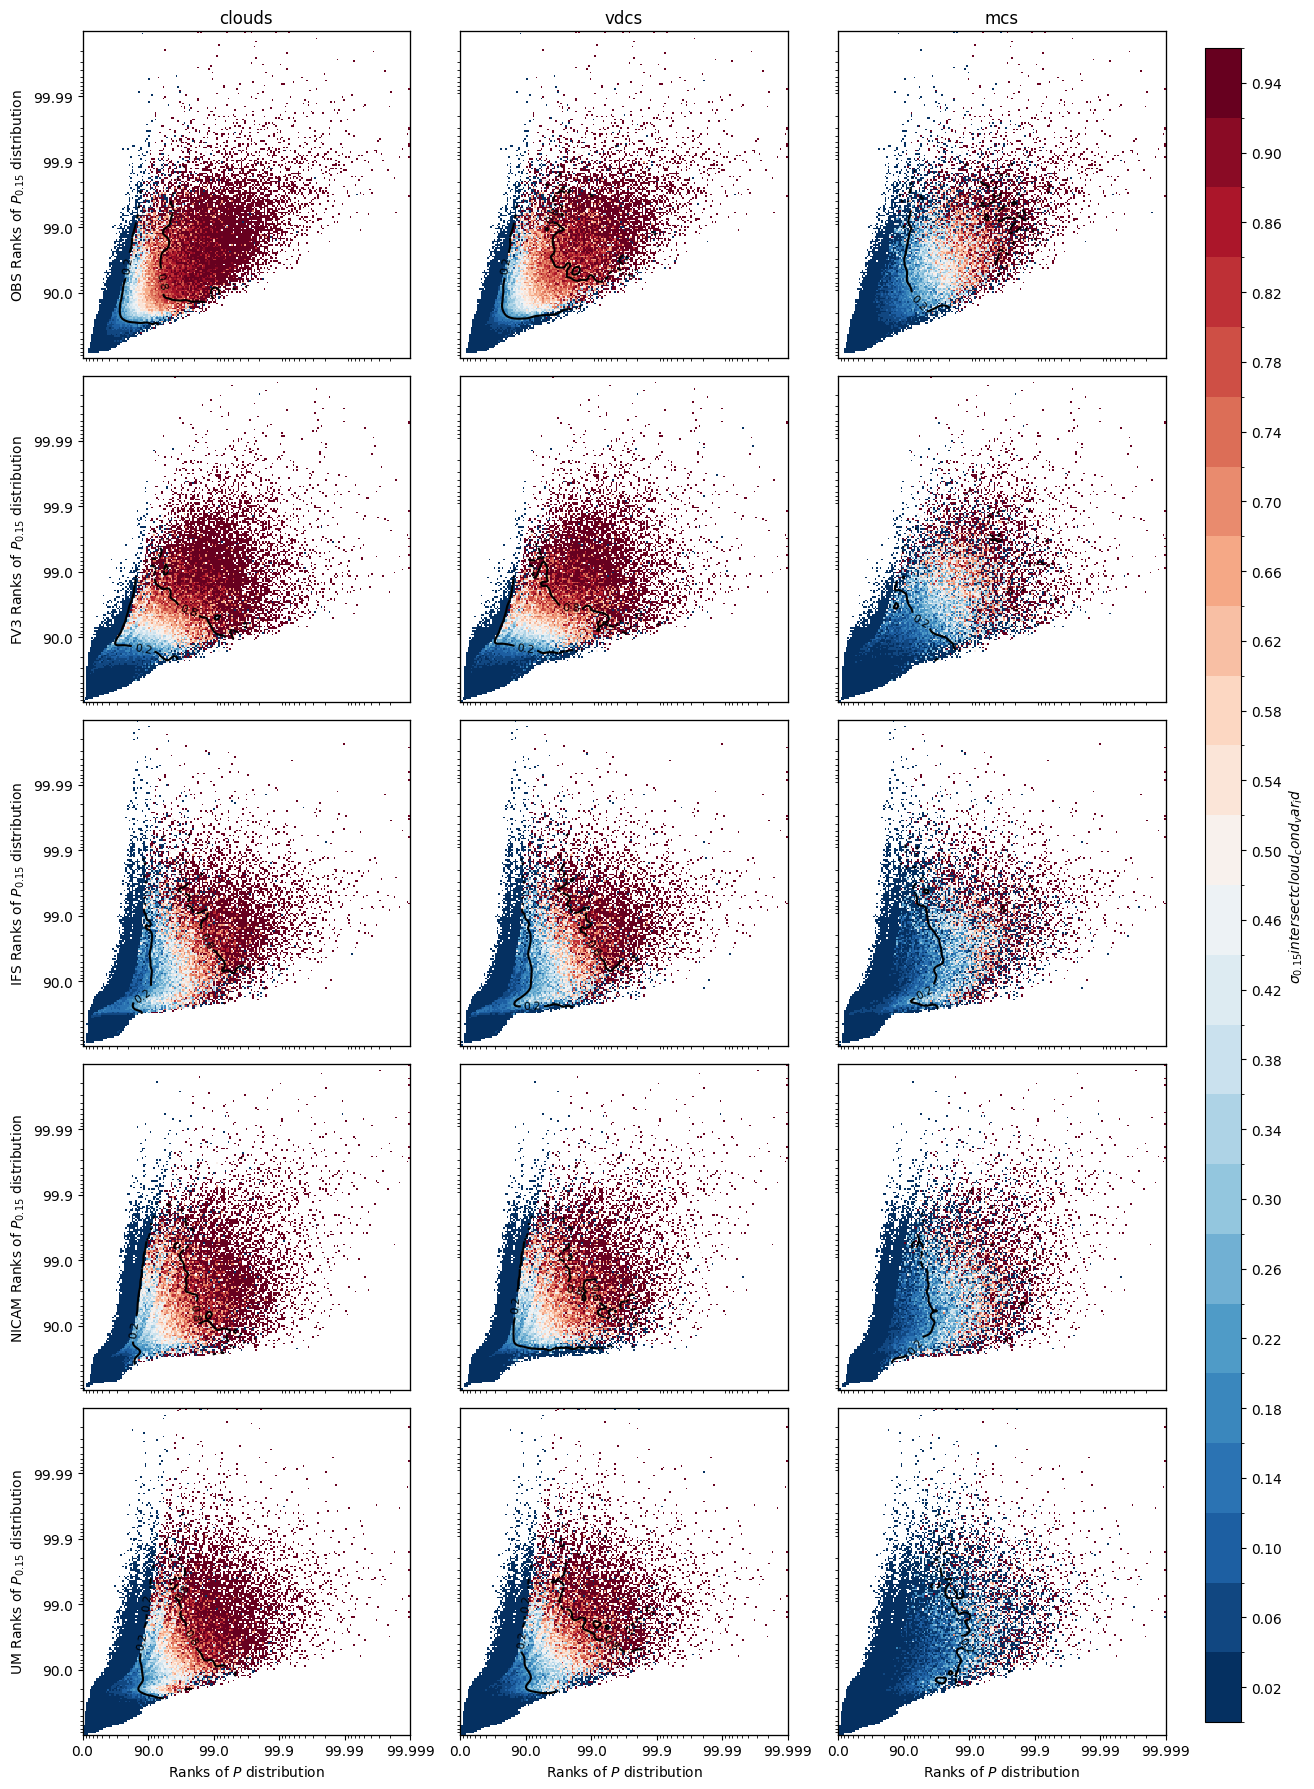

In [27]:
import pickle 
import os 

fig, axs = plt.subplots(5, 3, figsize=(12.1, 18))  # , sharex=True, sharey=True)

plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01, hspace=0.01)

cloud_cond_var_ids = ["clouds_cond_prec_15", "vdcs_cond_prec_15", "mcs_cond_prec_15"]

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

def save_density(density, filename):
    with open(filename, 'wb') as f:
        pickle.dump(density, f)

def load_density(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

for i, (jd, gr, axes) in enumerate(zip(jds, grs, axs)):
    print(jd.name)
    for j, (cloud_cond_var_id, ax) in enumerate(zip(cloud_cond_var_ids, axes)):
        if i == 0: 
            title = cloud_cond_var_id.split("_")[0]
        else: 
            title = None
        
        density_filename = f'density_{jd.name}_nbpd_{jd.nbpd}_nd_{jd.nd}_{cloud_cond_var_id}.pkl'
        
        if os.path.exists(density_filename):
            density = load_density(density_filename)
            ax, cbar, ax_show, density = jd.plot_var_id_func_over_jdist(cloud_cond_var_id, title=title, func='intersection_over_half_intersection', 
                                                                        mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2), cmap=cmap, norm=norm, fig=fig, ax=ax,
                                                                        density = density
                                                                        )

        else:
            ax, cbar, ax_show, density = jd.plot_var_id_func_over_jdist(cloud_cond_var_id, title=title, func='intersection_over_half_intersection', mask=np.repeat(np.logical_or(~ocean, ocean), 30, axis=2), cmap=cmap, norm=norm, fig=fig, ax=ax)
            save_density(density, density_filename)
        
        cbar.remove()
        plot_smoothed_density_contours(density, [0.2, 0.8], fig, ax_show)

        if title is None:
            ax.set_title("")
        if j == 0:
            ax.set_ylabel(jd.name.split("_")[0] + r" Ranks of $P_{0.15}$ distribution")
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)
        if i == len(jds) - 1:
            ax.set_xlabel(r"Ranks of $P$ distribution")
        else: 
            ax.set_xlabel("")
            ax.tick_params(bottom=False, labelbottom=False)

plt.tight_layout()
cax = fig.add_axes([1, 0.04, 0.03, 0.93])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')
cbar.set_label(r'$\sigma_{0.15} intersect cloud_cond_var_id$')
# plt.savefig("figures/fig4.png")
        # fig.tight_layout()
        # plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')
        # # fig.tight_layout()
        # plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

# get that contours


In [3]:
def get_var_id_density_over_jdist(self, var_id, func, mask, cmap = plt.cm.viridis, title = "No title :( "):
    key = func+'_'+var_id
        # Trying to avoid the prec bug, maybe it's due to prec dataset already being open within jd
    if var_id == self.var_id : 
        ds_var = self.prec.sortby("days")[key]
    elif func == 'MCS':
        ds_var = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")[var_id]
    else :  
        ds_var = self.grid.get_var_id_ds(var_id).sortby("days")[key]
        
    var_days = list(ds_var.days.values)
    ds_var = ds_var.sel(days = var_days) #.where(mask) # redundant ? 
    var_over_density = self.compute_conditional_data_over_density(ds_var, mask = mask, plot_func = np.nanmean) #more a da than ds but whatever
    
    return var_over_density 

In [4]:
cloud_cond_var_ids = ["clouds_cond_prec_15", "vdcs_cond_prec_15", "mcs_cond_prec_15"]
cloud_cond_var_id = cloud_cond_var_ids[1]
cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

jd = jds[1] 

density = get_var_id_density_over_jdist(jd, var_id = cloud_cond_var_id, title="None",  func = 'intersection_over_half_intersection', mask = np.repeat(np.logical_or(~ocean, ocean), 30, axis=2))

NameError: name 'jds' is not defined

## smoothed density func

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy import ma
from skimage.restoration import inpaint

def plot_smoothed_density_contours(density, levels = [0.2, 0.8], fig =None, ax = None):
    # Example data array (replace this with your actual data array)
    data = density.T

    # smooth data and handles nan
    masked_data = ma.masked_invalid(data)
    inpaint_mask = np.isnan(data)
    inpainted_data = inpaint.inpaint_biharmonic(data, inpaint_mask)
    smoothed_data = gaussian_filter(inpainted_data, sigma=2)
    smoothed_data = np.where(np.isnan(data), np.nan, smoothed_data)

    # Define contour levels
    if fig is None and ax is None : fig, ax = plt.subplots(figsize=(10, 10))
    contours = ax.contour(smoothed_data, levels=levels, colors='black')
    ax.clabel(contours, inline=True, fontsize=8)

## create intersection

In [10]:
import os 
for jd, gr in zip(jds, grs):
    cloud_types = ["clouds_cond_prec_15", "vdcs_cond_prec_15", "mcs_cond_prec_15"]
    cloud_cond_var_ids = ["intersection_clouds_cond_prec_15", "intersection_vdcs_cond_prec_15", "intersection_mcs_cond_prec_15"]
    for cloud_cond_var_id, cloud_type in zip(cloud_cond_var_ids, cloud_types):
        mcs_cond = gr.get_var_id_ds(cloud_type)
        bool_covered = mcs_cond[cloud_cond_var_id]>0.5
        mcs_cond["intersection_over_half_"+cloud_cond_var_id] = bool_covered ## add this 
        mcs_cond_file = gr.get_var_ds_file(cloud_type)
        os.remove(mcs_cond_file)
        mcs_cond.to_netcdf(mcs_cond_file)

## reload storms (long)

In [14]:
# for gr in grs:
#     print(gr.casestudy)
#     st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = True, overwrite = False)
#     st = storm_tracker.StormTracker(gr, label_var_id = "MCS_Feng", overwrite_storms = True, overwrite = False)


< Tempest instance:
 . handler: <tempest.handler.Handler object at 0x1541853703d0>
 . settings: <class 'dict'>
 . verbose: True
 . overwrite: True
 . region: Tropics
 . model: FV3_lowRes
 . name: FV3_lowRes_Tropics
 . data_out: /homedata/mcarenso/tempest/FV3_lowRes_Tropics
 . i_t_min: 240
 . i_t_max: 960
 . range_t: range(240, 961)
 . lat_slice: slice(-30, 30, None)
 . lon_slice: slice(-180, 180, None)
 . days_i_t_per_var_id: <class 'dict'>
 . var_names_2d: ['pr', 'flut']
 . var_names_3d: []
 . variables_names: <class 'list'>
 . new_variables_names: <class 'list'>
 . new_var_dependencies: <class 'dict'>
 . new_var_functions: <class 'dict'>
 >


IndexError: list index out of range